Loaded seaice.csv with shape: (26354, 7)
Head:
   Year   Month   Day       Extent      Missing  \
0  1978      10    26       10.231          0.0   
1  1978      10    28       10.420          0.0   
2  1978      10    30       10.557          0.0   
3  1978      11     1       10.670          0.0   
4  1978      11     3       10.777          0.0   

                                         Source Data hemisphere  
0   ['ftp://sidads.colorado.edu/pub/DATASETS/nsid...      north  
1   ['ftp://sidads.colorado.edu/pub/DATASETS/nsid...      north  
2   ['ftp://sidads.colorado.edu/pub/DATASETS/nsid...      north  
3   ['ftp://sidads.colorado.edu/pub/DATASETS/nsid...      north  
4   ['ftp://sidads.colorado.edu/pub/DATASETS/nsid...      north  
Prepared tidy df head:
            date   value
0     1978-10-26  10.231
13177 1978-10-26  17.624
1     1978-10-28  10.420
13178 1978-10-28  17.803
2     1978-10-30  10.557
Annual summary head:
   year      value
0  1978  12.976838
1  1979  12.019349

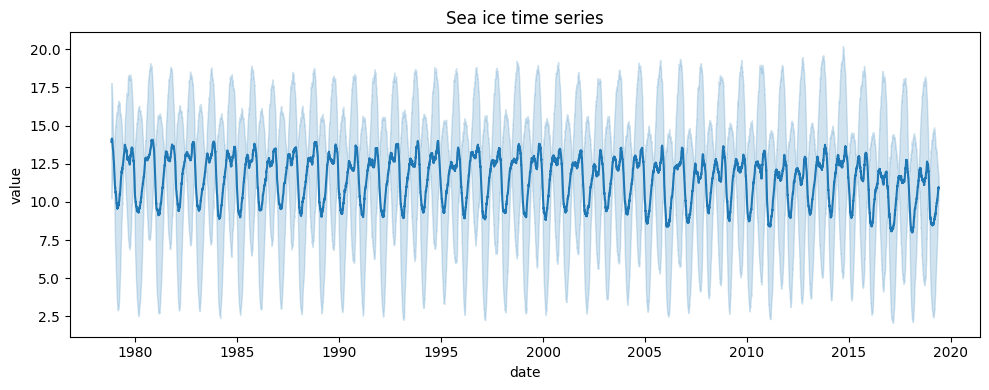

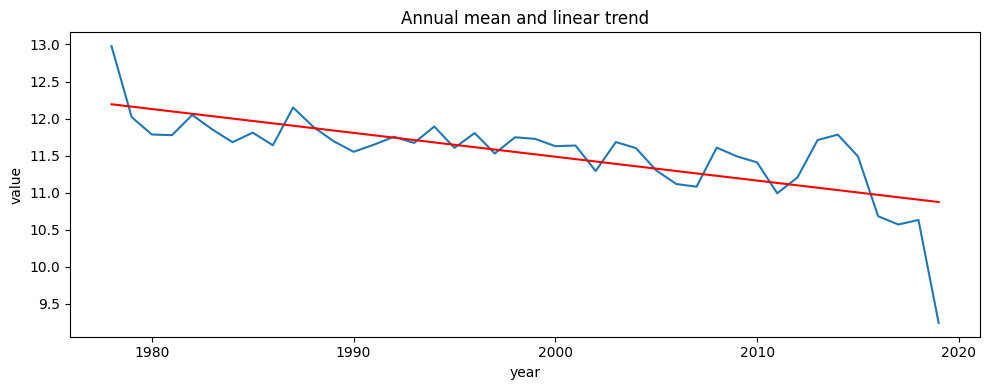

Saved files:
seaice_monthly_mean.csv
seaice_annual_mean.csv
Done processing seaice.csv


In [11]:
# Data project on seaice.csv: load, preview head, clean dates, summarize trends, simple plots, and export a tidy summary.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:', df_seaice.shape)
print('Head:')
print(df_seaice.head())

# 2) Normalize column names for robust matching
df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build dates directly from Year/Month/Day (no synthetic ranges)
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

date = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Choose value column (Extent)
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Tidy dataframe
df = pd.DataFrame({'date': date, 'value': df_seaice[val_col]}).dropna(subset=['date','value']).sort_values('date')
print('Prepared tidy df head:')
print(df.head())

# 3) Monthly and annual summaries
monthly = df.copy()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly_mean = monthly.groupby(['year','month'], as_index=False)['value'].mean()
monthly_mean['date'] = pd.to_datetime(monthly_mean['year'].astype(str) + '-' + monthly_mean['month'].astype(str) + '-01')

annual = df.copy()
annual['year'] = annual['date'].dt.year
annual_mean = annual.groupby('year', as_index=False)['value'].mean()

print('Annual summary head:')
print(annual_mean.head())

print('Prepared tidy df head:')
print(df.head())

# Linear trend on annual means
x = annual_mean['year'].values
yvals = annual_mean['value'].values
slope = np.polyfit(x, yvals, 1)[0] if len(annual_mean) > 1 else np

print('Estimated trend per year:')
print(slope)

# 4) Plots
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x='date', y='value')
plt.title('Sea ice time series')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.lineplot(data=annual_mean, x='year', y='value')
if len(annual_mean) > 1:
    coef = np.polyfit(annual_mean['year'], annual_mean['value'], 1)
    yy = np.polyval(coef, annual_mean['year'])
plt.plot(annual_mean['year'], yy, color='red')
plt.title('Annual mean and linear trend')
plt.tight_layout()
plt.show()

# 5) Save outputs
monthly_mean[['date','value']].to_csv('seaice_monthly_mean.csv', index=False)
annual_mean.to_csv('seaice_annual_mean.csv', index=False)
print('Saved files:')
print('seaice_monthly_mean.csv')
print('seaice_annual_mean.csv')
print('Done processing seaice.csv')

Loaded seaice.csv with shape:
(26354, 7)
Tidy head:
            date   value hemisphere
0     1978-10-26  10.231      north
13177 1978-10-26  17.624      south
1     1978-10-28  10.420      north
13178 1978-10-28  17.803      south
2     1978-10-30  10.557      north
Annual means head:
  hemisphere  year      value
0      north  1978  12.487000
1      north  1979  12.319560
2      north  1980  12.334148
3      north  1981  12.135486
4      north  1982  12.439445
Trends per year:
  hemisphere  slope_per_year
0      north       -0.042347
1      south       -0.021988


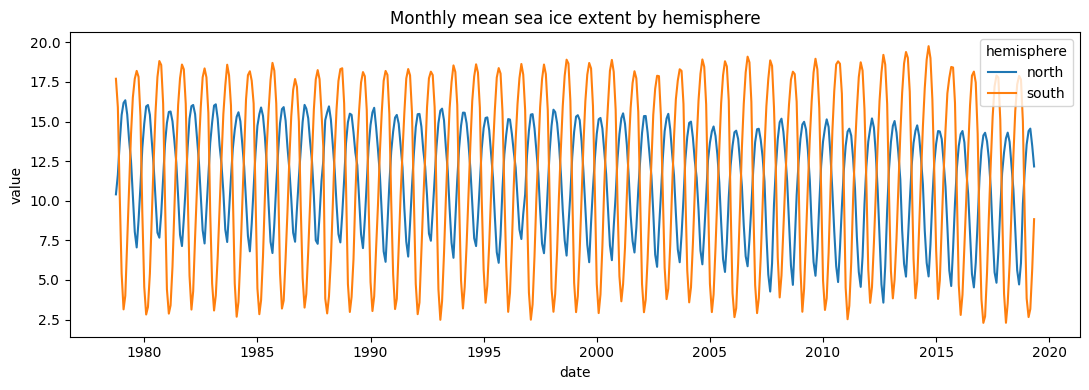

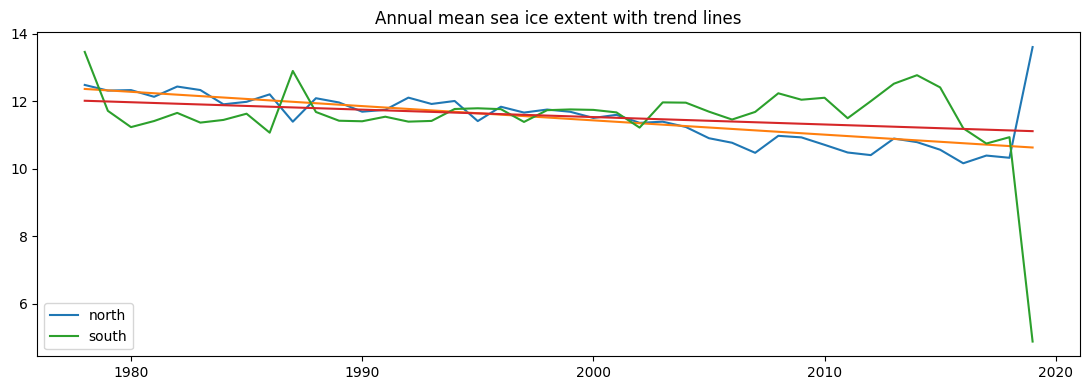

Saved files:
seaice_monthly_mean_by_hemisphere.csv
seaice_annual_mean_by_hemisphere.csv
seaice_trends_by_hemisphere.csv
Done comparing hemispheres


In [12]:
# Compare Arctic (north) and Antarctic (south) sea ice from seaice.csv: load, tidy, split by hemisphere, aggregate monthly/annual, plot, and export.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load existing in-memory or from disk
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:')
print(df_seaice.shape)

# Normalize columns
df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build date
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

dates = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Hemisphere column normalization
hem_col = 'hemisphere' if 'hemisphere' in df_seaice.columns else ('Hemisphere' if 'Hemisphere' in df_seaice.columns else None)
if hem_col is None:
    # Try to infer from Source Data path if present
    if 'Source Data' in df_seaice.columns:
        src = df_seaice['Source Data'].astype(str).str.lower()
        hemi = np.where(src.str.contains('/north/'), 'north', np.where(src.str.contains('/south/'), 'south', np.nan))
    else:
        hemi = np.nan
else:
    hemi = df_seaice[hem_col].astype(str).str.lower()

# Value column
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Tidy
df = pd.DataFrame({
    'date': dates,
    'value': df_seaice[val_col],
    'hemisphere': hemi
}).dropna(subset=['date','value','hemisphere']).sort_values('date')

print('Tidy head:')
print(df.head())

# Monthly means per hemisphere
monthly = df.copy()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly_mean = monthly.groupby(['hemisphere','year','month'], as_index=False)['value'].mean()
monthly_mean['date'] = pd.to_datetime(monthly_mean['year'].astype(str) + '-' + monthly_mean['month'].astype(str) + '-01')

# Annual means per hemisphere
annual_mean = df.assign(year=df['date'].dt.year).groupby(['hemisphere','year'], as_index=False)['value'].mean()

print('Annual means head:')
print(annual_mean.head())

# Compute simple linear trends per hemisphere on annual means
trends = []
for hemi_name, g in annual_mean.groupby('hemisphere'):
    if len(g) > 1:
        coef = np.polyfit(g['year'].values, g['value'].values, 1)
        trends.append({'hemisphere': hemi_name, 'slope_per_year': coef[0]})
    else:
        trends.append({'hemisphere': hemi_name, 'slope_per_year': np.nan})
trends_df = pd.DataFrame(trends)
print('Trends per year:')
print(trends_df)

# Plot monthly time series by hemisphere
plt.figure(figsize=(11,4))
sns.lineplot(data=monthly_mean, x='date', y='value', hue='hemisphere')
plt.title('Monthly mean sea ice extent by hemisphere')
plt.tight_layout()
plt.show()

# Plot annual means with trend lines
plt.figure(figsize=(11,4))
for hemi_name, g in annual_mean.groupby('hemisphere'):
    g = g.sort_values('year')
    plt.plot(g['year'], g['value'], label=hemi_name)
    if len(g) > 1:
        coef = np.polyfit(g['year'].values, g['value'].values, 1)
        yy = np.polyval(coef, g['year'].values)
        plt.plot(g['year'], yy)
plt.legend()
plt.title('Annual mean sea ice extent with trend lines')
plt.tight_layout()
plt.show()

# Export
monthly_mean.to_csv('seaice_monthly_mean_by_hemisphere.csv', index=False)
annual_mean.to_csv('seaice_annual_mean_by_hemisphere.csv', index=False)
trends_df.to_csv('seaice_trends_by_hemisphere.csv', index=False)
print('Saved files:')
print('seaice_monthly_mean_by_hemisphere.csv')
print('seaice_annual_mean_by_hemisphere.csv')
print('seaice_trends_by_hemisphere.csv')
print('Done comparing hemispheres')

Loaded seaice.csv with shape:
(26354, 7)
Decadal trend head:
  hemisphere  decade  start_year  end_year  years_covered  trend_per_year  \
0      north    1970        1978      1979              1       -0.167440   
1      north    1980        1980      1989              9       -0.055285   
2      north    1990        1990      1999              9       -0.018314   
3      north    2000        2000      2009              9       -0.098134   
4      north    2010        2010      2019              9        0.136386   

   trend_per_decade  
0         -1.674396  
1         -0.552846  
2         -0.183143  
3         -0.981343  
4          1.363865  


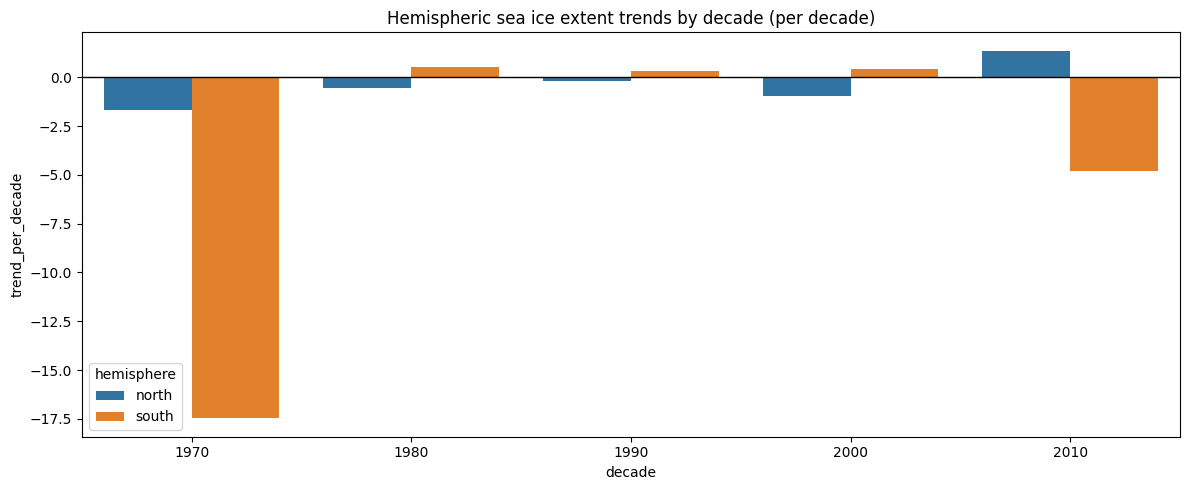

Saved file:
seaice_decadal_trends_by_hemisphere.csv
Done computing decadal trends


In [13]:
# Compute decadal linear trends per hemisphere from seaice.csv and plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:')
print(df_seaice.shape)

df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build date from Year/Month/Day
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

dates = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Hemisphere
hem_col = 'hemisphere' if 'hemisphere' in df_seaice.columns else ('Hemisphere' if 'Hemisphere' in df_seaice.columns else None)
if hem_col is None:
    if 'Source Data' in df_seaice.columns:
        src = df_seaice['Source Data'].astype(str).str.lower()
        hemi = np.where(src.str.contains('/north/'), 'north', np.where(src.str.contains('/south/'), 'south', np.nan))
    else:
        hemi = np.nan
else:
    hemi = df_seaice[hem_col].astype(str).str.lower()

# Value
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Tidy daily
df = pd.DataFrame({'date': dates, 'value': df_seaice[val_col], 'hemisphere': hemi}).dropna(subset=['date','value','hemisphere']).sort_values('date')

# Annual means per hemisphere
annual = df.assign(year=df['date'].dt.year).groupby(['hemisphere','year'], as_index=False)['value'].mean()

# Define decade bin (e.g., 1970s -> 1970, 1980s -> 1980, ...)
annual['decade'] = (annual['year'] // 10) * 10

# For each hemisphere and decade, compute linear trend within that decade
records = []
for (hemi_name, dec), g in annual.groupby(['hemisphere','decade']):
    g = g.sort_values('year')
    if len(g) >= 2:
        coef = np.polyfit(g['year'].values, g['value'].values, 1)
        slope = coef[0]
        start_year = int(g['year'].min())
        end_year = int(g['year'].max())
        n_years = end_year - start_year
    else:
        slope = np.nan
        start_year = int(g['year'].min()) if len(g) == 1 else np.nan
        end_year = int(g['year'].max()) if len(g) == 1 else np.nan
        n_years = 0
    records.append({
        'hemisphere': hemi_name,
        'decade': int(dec),
        'start_year': start_year,
        'end_year': end_year,
        'years_covered': n_years,
        'trend_per_year': slope,
        'trend_per_decade': slope * 10 if pd.notna(slope) else np.nan
    })

decadal_trends = pd.DataFrame(records).sort_values(['hemisphere','decade'])
print('Decadal trend head:')
print(decadal_trends.head())

# Plot bar chart of trend per decade for each hemisphere
plt.figure(figsize=(12,5))
sns.barplot(data=decadal_trends, x='decade', y='trend_per_decade', hue='hemisphere')
plt.axhline(0, color='black', linewidth=1)
plt.title('Hemispheric sea ice extent trends by decade (per decade)')
plt.tight_layout()
plt.show()

# Export
decadal_trends.to_csv('seaice_decadal_trends_by_hemisphere.csv', index=False)
print('Saved file:')
print('seaice_decadal_trends_by_hemisphere.csv')
print('Done computing decadal trends')

Loaded seaice.csv with shape:
(26354, 7)
Anomalies head:
  hemisphere  year  month      value       date  climatology   anomaly
0      north  1978     10  10.402667 1978-10-01     8.090064  2.312603
1      north  1978     11  11.645133 1978-11-01    10.536837  1.108297
2      north  1978     12  13.667063 1978-12-01    12.714227  0.952835
3      north  1979      1  15.414000 1979-01-01    14.267687  1.146313
4      north  1979      2  16.175286 1979-02-01    15.128938  1.046348


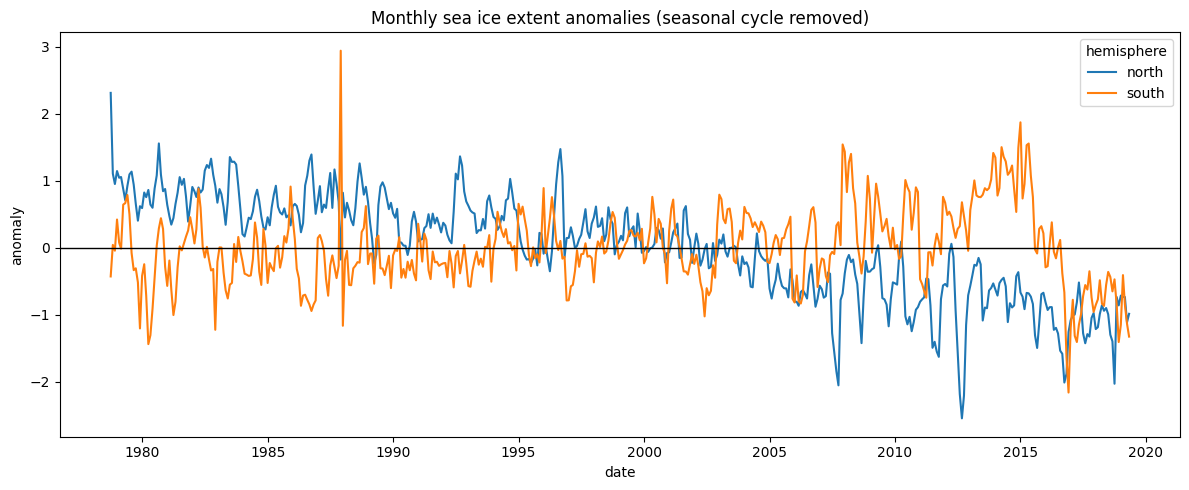

Seasonal amplitude by hemisphere:
  hemisphere  seasonal_amplitude
0      north            9.175892
1      south           15.465229
Anomaly trend per year:
  hemisphere  anomaly_trend_per_year
0      north               -0.055080
1      south                0.008734
Saved files:
seaice_monthly_climatology_by_hemisphere.csv
seaice_monthly_anomalies_by_hemisphere.csv
seaice_seasonal_amplitude_by_hemisphere.csv
seaice_anomaly_trends_by_hemisphere.csv
Done seasonal cycle analysis


In [14]:
# Remove seasonal cycle to compute anomalies per hemisphere, visualize, and export

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:')
print(df_seaice.shape)

df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build date from Year/Month/Day
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

dates = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Hemisphere detection
hem_col = 'hemisphere' if 'hemisphere' in df_seaice.columns else ('Hemisphere' if 'Hemisphere' in df_seaice.columns else None)
if hem_col is None:
    if 'Source Data' in df_seaice.columns:
        src = df_seaice['Source Data'].astype(str).str.lower()
        hemi = np.where(src.str.contains('/north/'), 'north', np.where(src.str.contains('/south/'), 'south', np.nan))
    else:
        hemi = np.nan
else:
    hemi = df_seaice[hem_col].astype(str).str.lower()

# Value column
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Tidy daily
df = pd.DataFrame({'date': dates, 'value': df_seaice[val_col], 'hemisphere': hemi}).dropna(subset=['date','value','hemisphere']).sort_values('date')

# Aggregate to monthly to define a consistent seasonal cycle
monthly = df.assign(year=df['date'].dt.year, month=df['date'].dt.month)
monthly_mean = monthly.groupby(['hemisphere','year','month'], as_index=False)['value'].mean()
monthly_mean['date'] = pd.to_datetime(monthly_mean['year'].astype(str) + '-' + monthly_mean['month'].astype(str) + '-01')

# Climatic seasonal cycle: long-term mean for each calendar month per hemisphere
clim = monthly_mean.groupby(['hemisphere','month'], as_index=False)['value'].mean().rename(columns={'value':'climatology'})

# Merge and compute anomalies
anoms = monthly_mean.merge(clim, on=['hemisphere','month'], how='left')
anoms['anomaly'] = anoms['value'] - anoms['climatology']

print('Anomalies head:')
print(anoms.head())

# Plot anomalies time series
plt.figure(figsize=(12,5))
sns.lineplot(data=anoms, x='date', y='anomaly', hue='hemisphere')
plt.axhline(0, color='black', linewidth=1)
plt.title('Monthly sea ice extent anomalies (seasonal cycle removed)')
plt.tight_layout()
plt.show()

# Quantify seasonal cycle amplitude (peak-to-trough) per hemisphere
amp = clim.groupby('hemisphere')['climatology'].agg(lambda s: s.max() - s.min()).reset_index().rename(columns={'climatology':'seasonal_amplitude'})
print('Seasonal amplitude by hemisphere:')
print(amp)

# Compute trend on anomalies per hemisphere (should reflect non-seasonal changes)
trend_records = []
for hemi_name, g in anoms.groupby('hemisphere'):
    g = g.sort_values('date')
    if len(g) > 1:
        x = g['date'].map(pd.Timestamp.toordinal).values
        yvals = g['anomaly'].values
        coef = np.polyfit(x, yvals, 1)
        slope_per_day = coef[0]
        slope_per_year = slope_per_day * 365.25
        trend_records.append({'hemisphere': hemi_name, 'anomaly_trend_per_year': slope_per_year})
    else:
        trend_records.append({'hemisphere': hemi_name, 'anomaly_trend_per_year': np.nan})
trend_df = pd.DataFrame(trend_records)
print('Anomaly trend per year:')
print(trend_df)

# Export
clim.to_csv('seaice_monthly_climatology_by_hemisphere.csv', index=False)
anoms.to_csv('seaice_monthly_anomalies_by_hemisphere.csv', index=False)
amp.to_csv('seaice_seasonal_amplitude_by_hemisphere.csv', index=False)
trend_df.to_csv('seaice_anomaly_trends_by_hemisphere.csv', index=False)
print('Saved files:')
print('seaice_monthly_climatology_by_hemisphere.csv')
print('seaice_monthly_anomalies_by_hemisphere.csv')
print('seaice_seasonal_amplitude_by_hemisphere.csv')
print('seaice_anomaly_trends_by_hemisphere.csv')
print('Done seasonal cycle analysis')

Loaded seaice.csv with shape:
(26354, 7)
Monthly trends head:
  hemisphere  month  trend_per_year  trend_per_decade
0      north      1       -0.047417         -0.474166
1      north      2       -0.046196         -0.461961
2      north      3       -0.041741         -0.417412
3      north      4       -0.038820         -0.388205
4      north      5       -0.036401         -0.364012
Seasonal sensitivity summary:
  hemisphere  min_month  min_trend_per_year  max_month  max_trend_per_year
0      north        9.0           -0.082359        5.0           -0.036401
1      south       11.0            0.000564        6.0            0.016741


C:\Users\kmaso\AppData\Local\Temp\ipykernel_23988\3393417997.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sensitivity = monthly_trends.groupby('hemisphere').apply(lambda x: pd.Series({


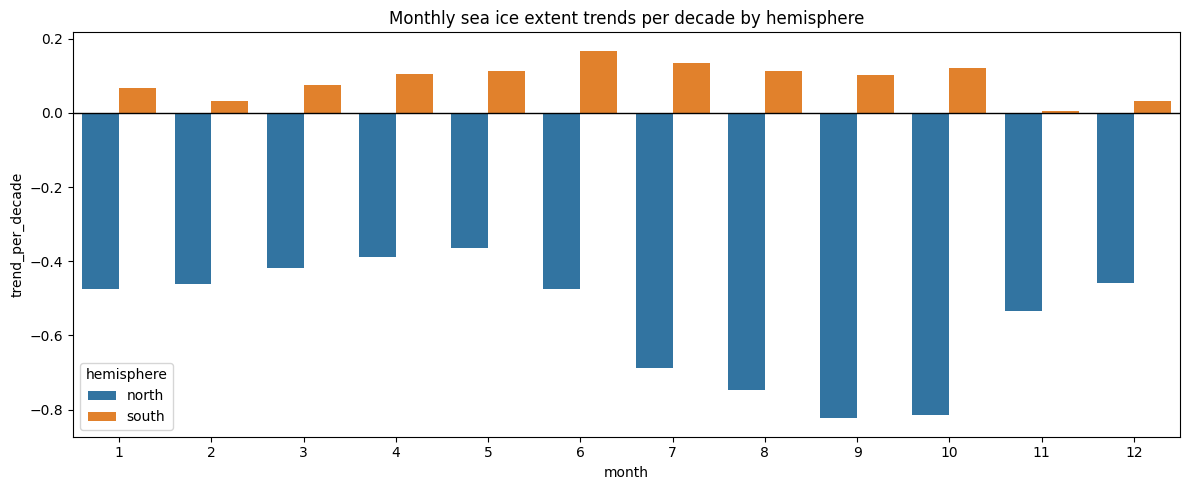

Saved files:
seaice_monthly_trends_by_hemisphere.csv
seaice_seasonal_sensitivity_summary.csv
Done seasonal sensitivity analysis


In [15]:
# Seasonal sensitivity analysis: compute monthly trends per hemisphere, summarize peak seasons, and plot.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:')
print(df_seaice.shape)

df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build date from Year/Month/Day
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

dates = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Hemisphere label
hem_col = 'hemisphere' if 'hemisphere' in df_seaice.columns else ('Hemisphere' if 'Hemisphere' in df_seaice.columns else None)
if hem_col is None:
    if 'Source Data' in df_seaice.columns:
        src = df_seaice['Source Data'].astype(str).str.lower()
        hemi = np.where(src.str.contains('/north/'), 'north', np.where(src.str.contains('/south/'), 'south', np.nan))
    else:
        hemi = np.nan
else:
    hemi = df_seaice[hem_col].astype(str).str.lower()

# Value column
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Tidy daily
df = pd.DataFrame({'date': dates, 'value': df_seaice[val_col], 'hemisphere': hemi}).dropna(subset=['date','value','hemisphere']).sort_values('date')

# Aggregate to monthly
monthly = df.assign(year=df['date'].dt.year, month=df['date'].dt.month)
monthly_mean = monthly.groupby(['hemisphere','year','month'], as_index=False)['value'].mean()
monthly_mean['date'] = pd.to_datetime(monthly_mean['year'].astype(str) + '-' + monthly_mean['month'].astype(str) + '-01')

# For each hemisphere and month, compute linear trend (units per year)
trend_rows = []
for hemi_name, g_hemi in monthly_mean.groupby('hemisphere'):
    for mth, g in g_hemi.groupby('month'):
        g = g.sort_values('year')
        if len(g) > 1:
            coef = np.polyfit(g['year'].values, g['value'].values, 1)
            slope = coef[0]
        else:
            slope = np.nan
        trend_rows.append({'hemisphere': hemi_name, 'month': int(mth), 'trend_per_year': slope, 'trend_per_decade': slope * 10 if pd.notna(slope) else np.nan})

monthly_trends = pd.DataFrame(trend_rows)
print('Monthly trends head:')
print(monthly_trends.head())

# Identify seasonal sensitivity: most negative and most positive months per hemisphere
sensitivity = monthly_trends.groupby('hemisphere').apply(lambda x: pd.Series({
    'min_month': int(x.loc[x['trend_per_year'].idxmin(), 'month']) if x['trend_per_year'].notna().any() else np.nan,
    'min_trend_per_year': x['trend_per_year'].min(),
    'max_month': int(x.loc[x['trend_per_year'].idxmax(), 'month']) if x['trend_per_year'].notna().any() else np.nan,
    'max_trend_per_year': x['trend_per_year'].max()
})).reset_index()
print('Seasonal sensitivity summary:')
print(sensitivity)

# Plot monthly trends by hemisphere
plt.figure(figsize=(12,5))
sns.barplot(data=monthly_trends, x='month', y='trend_per_decade', hue='hemisphere')
plt.axhline(0, color='black', linewidth=1)
plt.title('Monthly sea ice extent trends per decade by hemisphere')
plt.tight_layout()
plt.show()

# Save outputs
monthly_trends.to_csv('seaice_monthly_trends_by_hemisphere.csv', index=False)
sensitivity.to_csv('seaice_seasonal_sensitivity_summary.csv', index=False)
print('Saved files:')
print('seaice_monthly_trends_by_hemisphere.csv')
print('seaice_seasonal_sensitivity_summary.csv')
print('Done seasonal sensitivity analysis')

Installing ruptures now
Defaulting to user installation because normal site-packages is not writeable
  Using cached ruptures-1.1.9.tar.gz (308 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build ruptures
Note: you may need to restart the kernel to use updated packages.
ruptures still not importable; will use fallback method
Loaded seaice.csv with shape:
(26354, 7)
Annual means head:
  hemisphere  year      value
0      north  1978  12.487000
1      north  1979  12.319560
2      north  1980  12.334148
3      north  1981  12.135486
4      north  1982  12.439445
Fallback change point for north: 2002


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [100 lines of output]
  C:\Users\kmaso\AppData\Local\Temp\pip-build-env-uu3aqysu\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
  !!
  
          ********************************************************************************
          Please consider removing the following classifiers in favor of a SPDX license expression:
  
          License :: OSI Approved :: BSD License
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    self._finalize_license_expression()
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-313\ruptures
  copying src\ruptures\base.py -> build\lib.win-amd64-cpython-313\ruptures
  copying src\ruptures\exceptions.py -> build\lib.win-amd64-

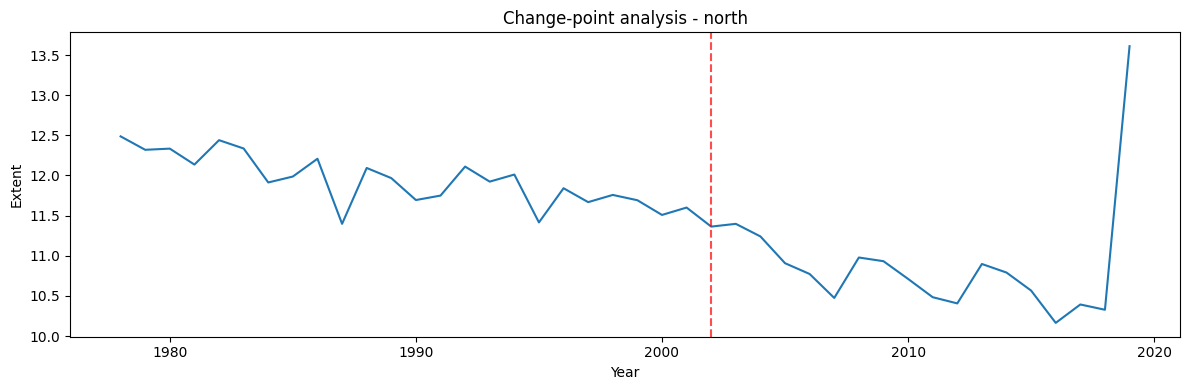

Fallback change point for south: 2017


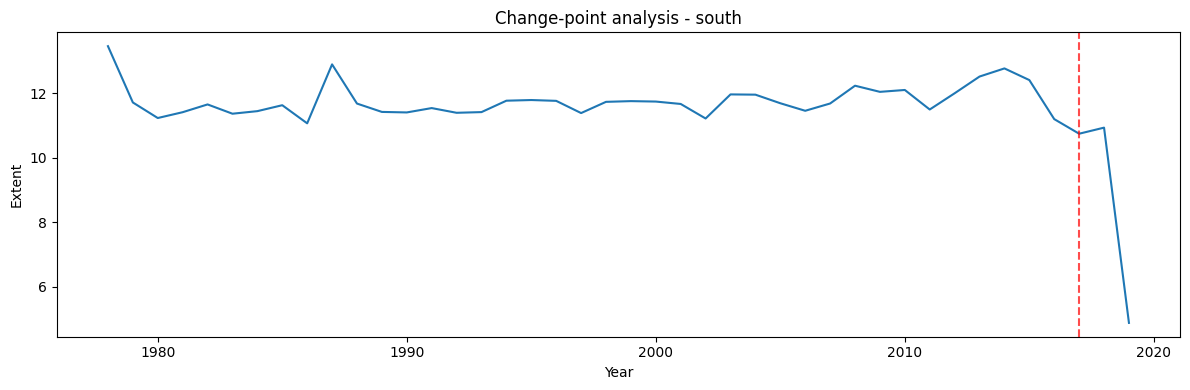

Detected change points:
  hemisphere change_points_years
0      north              [2002]
1      south              [2017]
Saved files:
seaice_annual_means_by_hemisphere.csv
seaice_change_points_by_hemisphere.csv
Done change-point analysis with fallback


In [19]:
# Fresh install and verification of ruptures, then rerun change-point detection using an alternative (numpy) fallback if import fails.

# Step 1: Try clean install of ruptures in its own cell
try:
    import ruptures as rpt
    print('ruptures already available')
except Exception:
    print('Installing ruptures now')
    %pip install ruptures
    try:
        import ruptures as rpt
        print('ruptures installed and imported')
    except Exception as e:
        print('ruptures still not importable; will use fallback method')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
seaice_path = 'seaice.csv'
df_seaice = pd.read_csv(seaice_path)
print('Loaded seaice.csv with shape:')
print(df_seaice.shape)

df_seaice.columns = [str(c).strip() for c in df_seaice.columns]

# Build date
y = pd.to_numeric(df_seaice['Year'], errors='coerce').astype('Int64')
m = pd.to_numeric(df_seaice['Month'], errors='coerce').astype('Int64')
d = pd.to_numeric(df_seaice['Day'] if 'Day' in df_seaice.columns else 1, errors='coerce').fillna(1).astype('Int64')

dates = pd.to_datetime(y.astype(str) + '-' + m.astype(str) + '-' + d.astype(str), errors='coerce')

# Hemisphere
hem_col = 'hemisphere' if 'hemisphere' in df_seaice.columns else ('Hemisphere' if 'Hemisphere' in df_seaice.columns else None)
if hem_col is None:
    if 'Source Data' in df_seaice.columns:
        src = df_seaice['Source Data'].astype(str).str.lower()
        hemi = np.where(src.str.contains('/north/'), 'north', np.where(src.str.contains('/south/'), 'south', np.nan))
    else:
        hemi = np.nan
else:
    hemi = df_seaice[hem_col].astype(str).str.lower()

# Value column
val_col = 'Extent' if 'Extent' in df_seaice.columns else df_seaice.select_dtypes(include='number').columns[0]

# Annual means by hemisphere

df = pd.DataFrame({'date': dates, 'value': df_seaice[val_col], 'hemisphere': hemi}).dropna(subset=['date','value','hemisphere']).sort_values('date')
annual = df.assign(year=df['date'].dt.year).groupby(['hemisphere','year'], as_index=False)['value'].mean().sort_values(['hemisphere','year'])
print('Annual means head:')
print(annual.head())

# Step 2: Change point detection
results = []

use_ruptures = 'rpt' in globals()

for hemi_name, g in annual.groupby('hemisphere'):
    years = g['year'].values
    yvals = g['value'].values

    cps_years = []
    if use_ruptures:
        try:
            algo = rpt.Pelt(model='l2').fit(yvals)
            bkpts = algo.predict(pen=3.0)
            change_idx = [i - 1 for i in bkpts[:-1]]
            cps_years = [int(years[i]) for i in change_idx]
            print('Used ruptures for ' + hemi_name)
        except Exception as e:
            print('ruptures failed for ' + hemi_name + ', using fallback')
            use_ruptures = False
    if not use_ruptures:
        # Fallback: two-segment SSE minimization to find one change point (binary segmentation single split)
        best_i = None
        best_sse = np.inf
        for i in range(2, len(yvals) - 2):
            mu1 = yvals[:i].mean()
            mu2 = yvals[i:].mean()
            sse = ((yvals[:i] - mu1) ** 2).sum() + ((yvals[i:] - mu2) ** 2).sum()
            if sse < best_sse:
                best_sse = sse
                best_i = i
        cps_years = [int(years[best_i])] if best_i is not None else []
        print('Fallback change point for ' + hemi_name + ': ' + (str(cps_years[0]) if cps_years else 'none'))

    results.append({'hemisphere': hemi_name, 'change_points_years': cps_years})

    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(years, yvals, label='Annual mean')
    for cp in cps_years:
        plt.axvline(cp, color='red', linestyle='--', alpha=0.7)
    plt.title('Change-point analysis - ' + hemi_name)
    plt.xlabel('Year')
    plt.ylabel('Extent')
    plt.tight_layout()
    plt.show()

cp_df = pd.DataFrame(results)
print('Detected change points:')
print(cp_df)

# Save
annual.to_csv('seaice_annual_means_by_hemisphere.csv', index=False)
cp_df.to_csv('seaice_change_points_by_hemisphere.csv', index=False)
print('Saved files:')
print('seaice_annual_means_by_hemisphere.csv')
print('seaice_change_points_by_hemisphere.csv')
print('Done change-point analysis with fallback')